# Import Libraries:

In [1]:
#importing all libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import Raw Data:
For the purposes of this model, we are using a dataset downloaded from kaggle at the following link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset.

This dataset is a composite dataset of three individual datasets, and contains more than 7,000 MRI images of the brain.

In [2]:
# Downloading the dataset from kaggle:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:00<00:00, 173MB/s]
100% 149M/149M [00:00<00:00, 185MB/s]


In [3]:
# Unzip dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

# Exploratory Data Analysis:
Display the first five MRI images for some Exploratory Data Analysis:

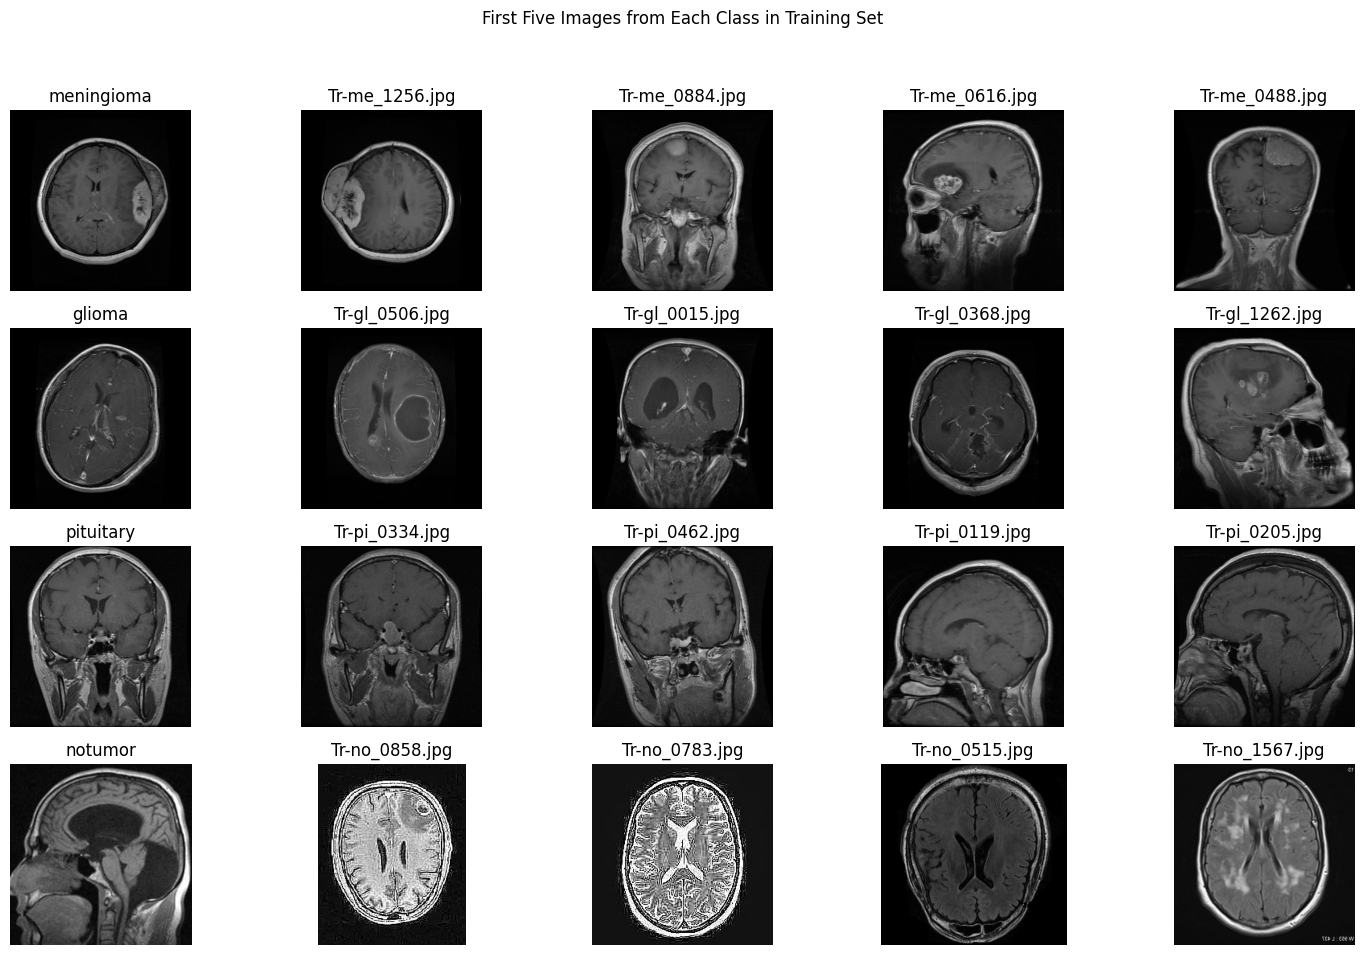

In [4]:
# Create directory paths for the training and testing directories:
training_path = 'brain-tumor-mri-dataset/Training'
testing_path = 'brain-tumor-mri-dataset/Testing'

# Display first five images from each class in the training set:
classes = os.listdir(training_path)

# Plot the training datatset since the data was pre-split between test and train:
fig, axs = plt.subplots(len(classes), 5, figsize=(15, 10))
fig.suptitle('First Five Images from Each Class in Training Set')

# Iterate through every image and plot the first five images from each class
for i, class_name in enumerate(classes):
    class_path = os.path.join(training_path, class_name)
    images = os.listdir(class_path)[:5]

    for j, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        img = mpimg.imread(image_path)
        axs[i, j].imshow((img), cmap='gray')
        axs[i, j].set_title(f'{image_name}')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Reviewing the size of the dataset:
Begin by creating a function that will count the number of images per class within the training and testing datasets:

In [5]:
# Count number of images per class:
def count_images_in_classes(path):
    """
    Counts the number of images in each class directory within the given path.

    Args:
        path (str): The directory path containing subdirectories for each class.

    Returns:
        dict: A dictionary where the keys are class names and the values are the number of images in each class.
    """
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts


In [6]:
# Count the images in both training and testing paths
training_counts = count_images_in_classes(training_path)
testing_counts = count_images_in_classes(testing_path)

# Calculate the total number of images in training and testing paths
train_sum = sum(training_counts.values())
test_sum = sum(testing_counts.values())

# Calculate the original train/test split percentage
original_train_test_split = train_sum / (test_sum + train_sum) * 100

# Print the results
print('Total number of images of dataset:', train_sum + test_sum)
print('Total training data size:', train_sum)
print('Total testing data size:', test_sum)
print('Training Counts:', training_counts)
print('Testing Counts:', testing_counts)
print('Original Train Split= ', original_train_test_split)
print('Original Test Split= ',(100-(original_train_test_split)))

Total number of images of dataset: 7023
Total training data size: 5712
Total testing data size: 1311
Training Counts: {'meningioma': 1339, 'glioma': 1321, 'pituitary': 1457, 'notumor': 1595}
Testing Counts: {'meningioma': 306, 'glioma': 300, 'pituitary': 300, 'notumor': 405}
Original Train Split=  81.33276377616403
Original Test Split=  18.66723622383597


From the results above, we find that the original split between training and testing datasets is approximately ~ 80/20%. For the purposes of this model, we will use this same split.

**Note:** There were some concerns over data leakage between the training and testing datsets, primarily because it was impossible to determine whether or not each patient had only one MRI. For the purposes of this model, we are choosing to trust that the creators of this dataset took this into account and have split the data accordingly, which is why we chose to use the original split.

### Visualize the Distribution of Classes:

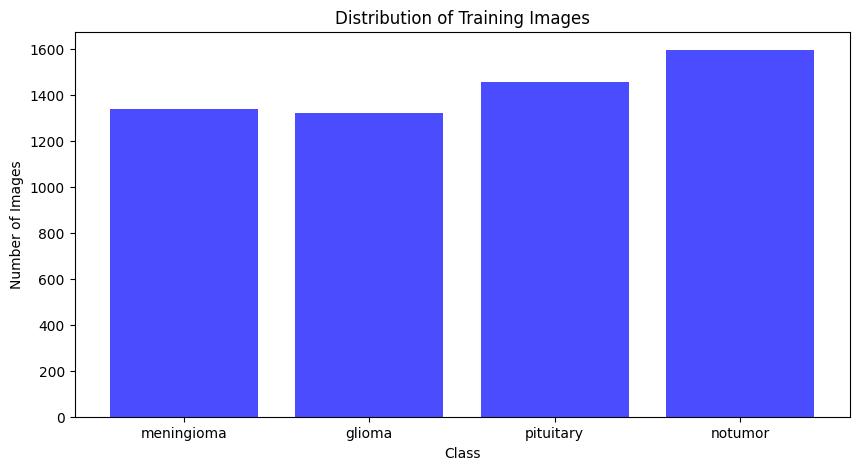

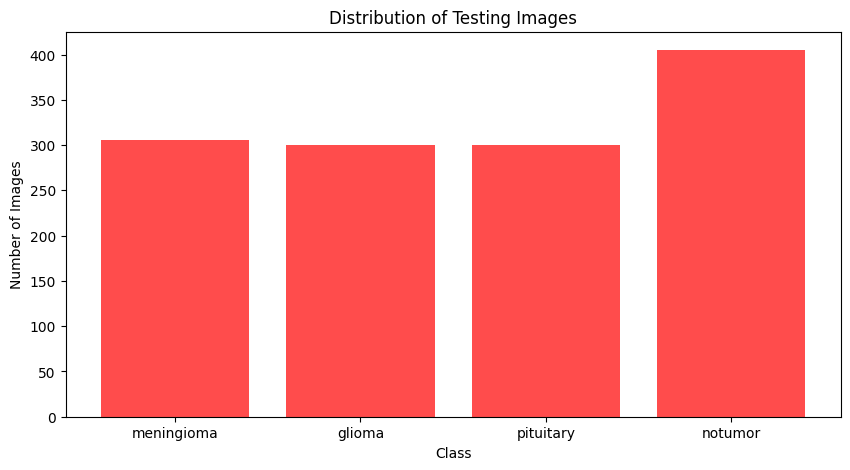

In [7]:
# Distribution of training images:
plt.figure(figsize=(10, 5))
plt.bar(training_counts.keys(), training_counts.values(), color='b', alpha=0.7)
plt.title('Distribution of Training Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Distribution of test images:
plt.figure(figsize=(10, 5))
plt.bar(testing_counts.keys(), testing_counts.values(), color='r', alpha=0.7)
plt.title('Distribution of Testing Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

Here we find that the 'no tumor' class is the majority class in both training and testing datasets. However, the data is mostly uniformly split among all classes.

### Check for Duplicate Images:
Because this dataset is a composite of three individual datasets, we must ensure that there are no duplicate images that could lead to data leakage.

We created a function that removes duplicates as follows:
1) Lists all the labels in the training directory.

2) Compute a unique hash for each file -> list all JPEG files and their hashes -> count the total number of files in a directory -> remove duplicate files based on their hashes.

3) Counts and prints the number of files in both directories and creates a dictionary to store the hashes of the files, lists all files to populate this dictionary, and removes any duplicates.

In [8]:
# Use the list of labels (subdirectories) in the training directory:
training_directory = os.path.join(training_path)
testing_directory = os.path.join(testing_path)
labels = os.listdir(training_directory)


def compute_file_hash(file_path):
    """
    Computes the MD5 hash of a file.

    Args:
        file_path (str): Path to the file.

    Returns:
        str: The MD5 hash of the file.
    """
    hasher = hashlib.md5()  # Create a new MD5 hash object
    with open(file_path, 'rb') as file:  # Open the file in binary read mode
        buffer = file.read()  # Read the entire file into memory
        hasher.update(buffer)  # Update the hash object with the file contents
    return hasher.hexdigest()  # Return the hexadecimal representation of the hash

def list_files_by_hash(hash_dict):
    """
    Lists all JPEG files in the training and testing directories, computes their hashes, and stores them in a dictionary.

    Args:
        hash_dict (dict): Dictionary to store file hashes and their paths.
    """
    for dataset_path in [training_directory, testing_directory]:
        for label in labels:
            folder_path = os.path.join(dataset_path, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):  # Only consider JPEG files
                        file_path = os.path.join(root, file)
                        file_hash = compute_file_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]

def count_files(directory_path):
    """
    Counts the total number of files in a directory and its subdirectories.

    Args:
        directory_path (str): Path to the directory.

    Returns:
        int: Total number of files in the directory.
    """
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

def remove_duplicates(hash_dict):
    """
    Removes duplicate files based on their hashes.

    Args:
        hash_dict (dict): Dictionary of file hashes and their paths.
    """
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:  # If more than one file has the same hash
            for file_path in file_paths[1:]:  # Keep the first file, remove the rest
                print(f"Removing duplicate (hash: {hash_value}): {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates removed: {duplicate_count}")

In [9]:
# Count and display the number of files before removing duplicates:
training_file_count_before = count_files(training_directory)
testing_file_count_before = count_files(testing_directory)

print(f"This is the training path size before removing duplicates: {training_file_count_before}")
print(f"This is the testing path size before removing duplicates: {testing_file_count_before}")

# Create a dictionary to store file hashes:
hash_dict = {}

# List all files and compute their hashes
list_files_by_hash(hash_dict)

# Remove duplicates
remove_duplicates(hash_dict)

# Count and display the number of files after removing duplicates
training_file_count_after = count_files(training_directory)
testing_file_count_after = count_files(testing_directory)

print(f"This is the training path size after removing duplicates: {training_file_count_after}")
print(f"This is the testing path size after removing duplicates: {testing_file_count_after}")

This is the training path size before removing duplicates: 5712
This is the testing path size before removing duplicates: 1311
Removing duplicate (hash: 832c3e0243e8fafe4313d899e233285d): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0617.jpg
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0176.jpg
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0211.jpg
Removing duplicate (hash: 333ca271271562e025951545e76a8b0b): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0251.jpg
Removing duplicate (hash: ab525628d00898aa6b1088d9c1d5a785): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0175.jpg
Removing duplicate (hash: b0481c04cf82055b53bed325556f744e): brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg
Removing duplicate (hash: a501e6ea3748d3aebea8e8735268ec5b): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0238.jpg
Removing duplicate (hash: 3cb1d659

In [10]:
# Count files per label after removing duplicates
# Show number of files per label:
training_counts = count_images_in_classes(training_path)
testing_counts = count_images_in_classes(testing_path)

print('Training Counts:', training_counts)
print('Testing Counts:', testing_counts)

# Reconfirm the train/test split
new_train_test_split = training_file_count_after / (training_file_count_after + testing_file_count_after)

print('Training% = ', new_train_test_split)
print('Testing% = ',(100/100-(new_train_test_split)))

Training Counts: {'meningioma': 1333, 'glioma': 1321, 'pituitary': 1445, 'notumor': 1422}
Testing Counts: {'meningioma': 302, 'glioma': 299, 'pituitary': 295, 'notumor': 309}
Training% =  0.820844484091585
Testing% =  0.17915551590841505


Initially the **training** dataset contained a total of 5712 files, with the following counts per label: 
- Glioma (1321) 
- Meningioma (1339)
- Pituitary (1457)
- No_tumor (1595)

Post-duplicate removal, the total count for the **training** dataset decreased to 5521 files, which included the the removal of 191 duplicate files. The updated counts for the training dataset are: 
- Glioma (1321) 
- Meningioma (1333) 
- Pituitary (1445) 
- No_tumor (1422)

Similarly, the **testing** dataset originally comprised 1311 files, with counts per label as follows: 
- Glioma (300) 
- Meningioma (306)
- Pituitary (300) 
- No_tumor (405)

After duplicates were removed, the **testing** dataset was reduced to 1205 files, reflecting the elimination of 106 duplicates. The revised counts for the testing dataset are: 
- Glioma (299)
- Meningioma (302) 
- Pituitary (295)
- No_tumor (309)

# Data Preprocessing:
After conducting some EDA upon the dataset, we move to preprocessing the data so that it is ready for model building. Below we have created a few diffferent functions that accomplish the following:

1) Load and resize each image from the training and testing directories, assigning labels based on the subdirectory name.

2) Encodes the labels into integers and shuffles the training data.

3) Split the training data into training and validation sets, with the training set augmented with new images by flipping all images horizontally.

4) Normalize each image and, for the training set, apply brightness and contrast adjustments.

In [11]:
def load_images_from_folder(folder, target_size=(224, 224)):
    """
    Loads and resizes images from a specified folder, assigning labels based on tumor type.

    Args:
        folder (str): Path to the main folder containing subdirectories for each label.
        target_size (tuple): Desired image size as (width, height). Default is (224, 224).

    Returns:
        np.ndarray: Array of images.
        np.ndarray: Array of labels corresponding to the images.
    """
    images = []
    labels = []

    # Get list of all files in directory:
    for label in os.listdir(folder):
        # Set label path for each image:
        label_path = os.path.join(folder, label)
        # Check if each file is a directory:
        if os.path.isdir(label_path):
            # Loop through each file:
            for filename in os.listdir(label_path):
                # Create a new path for each file:
                img_path = os.path.join(label_path, filename)
                # Read as grayscale image:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_size)  # Resize image to target size
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

def preprocess_data_part2(training_path, testing_path):
    """
    Preprocesses data by loading images, encoding labels, shuffling, splitting into training and validation sets,
    augmenting the training data, normalizing images, and applying brightness and contrast adjustments.

    Args:
        training_path (str): Path to the training data folder.
        testing_path (str): Path to the testing data folder.

    Returns:
        tuple: Preprocessed training, validation, and testing sets along with original training images,
               training indices, and label encoder.
    """
    #load images and labels from the training and testing paths
    X_train_raw, Y_train_raw = load_images_from_folder(training_path)
    X_test, Y_test = load_images_from_folder(testing_path)

    #encode labels to integers
    label_encoder = LabelEncoder()
    Y_train_raw = label_encoder.fit_transform(Y_train_raw)
    Y_test = label_encoder.transform(Y_test)

    #shuffle the training data
    train_indices = np.arange(len(X_train_raw))
    np.random.shuffle(train_indices)
    X_train_shuffled = X_train_raw[train_indices]
    Y_train_shuffled = Y_train_raw[train_indices]

    #split the training data into training (75%) and validation (25%) sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_shuffled, Y_train_shuffled, test_size=0.25, random_state=42)

    #save a copy of the training images before augmentation
    X_train_before_aug = X_train.copy()

    #augment training data by flipping images horizontally
    augmented_train_images = tf.image.flip_left_right(X_train)
    X_train = np.concatenate((X_train, augmented_train_images), axis=0)
    Y_train = np.concatenate((Y_train, Y_train), axis=0)

    #normalize images by dividing by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    #applying brightness and contrast adjustments to the training set only
    X_train = tf.image.adjust_brightness(X_train, delta=0.1)
    X_train = tf.image.adjust_contrast(X_train, contrast_factor=1)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, X_train_before_aug, train_indices, label_encoder

def show_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

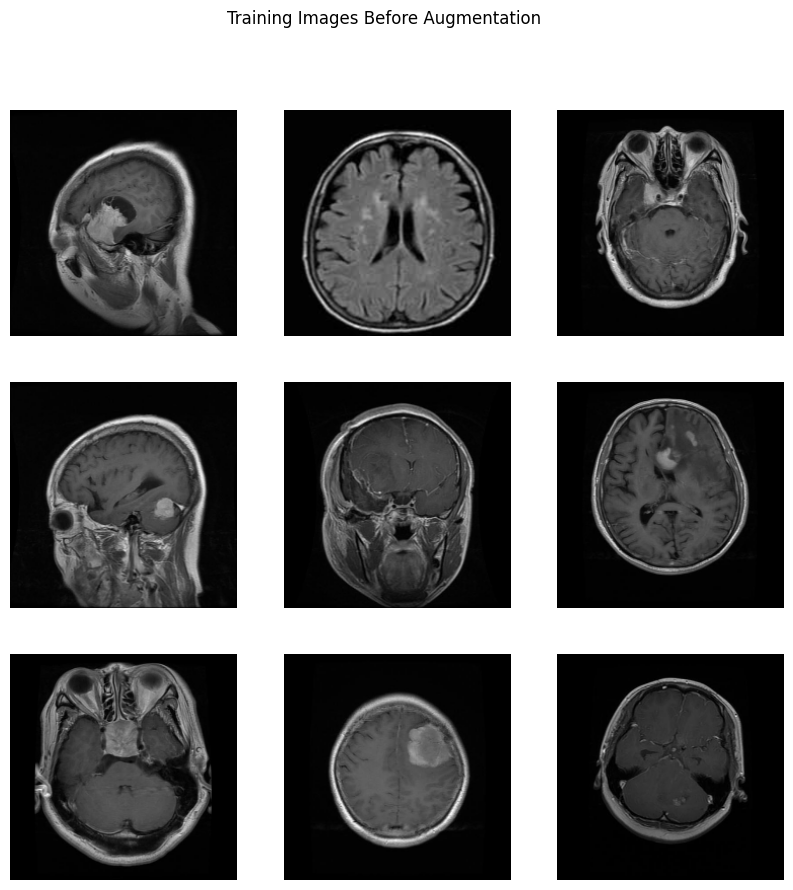

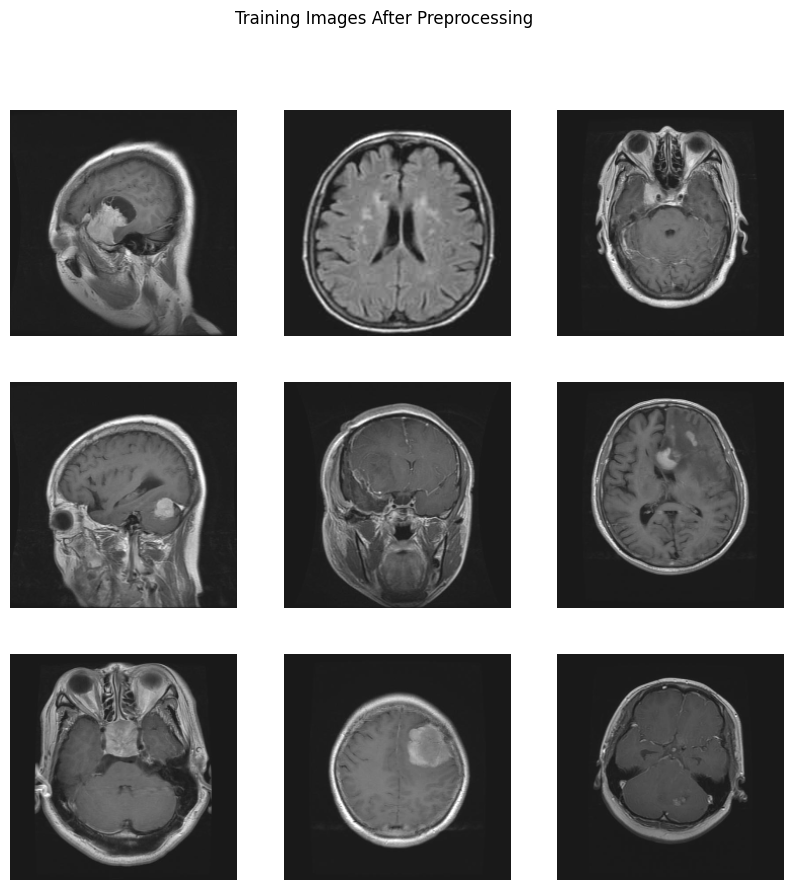

Training set size: 8280 images
Validation set size: 1381 images
Testing set size: 1205 images


In [12]:
# Define paths to training and testing datasets:
training_path = 'brain-tumor-mri-dataset/Training'
testing_path = 'brain-tumor-mri-dataset/Testing'

# Preprocess the data:
X_train, Y_train, X_val, Y_val, X_test, Y_test, X_train_before_aug, train_indices, label_encoder = preprocess_data_part2(training_path, testing_path)

# Display some examples prior to preprocessing:
show_images(X_train_before_aug[:9], "Training Images Before Augmentation")

# Display some examples post preprocessing
show_images(X_train.numpy()[:9], "Training Images After Preprocessing")

# Print length of each dataset:
print(f"Training set size: {len(X_train)} images")
print(f"Validation set size: {len(X_val)} images")
print(f"Testing set size: {len(X_test)} images")

### Final Verifications:
- Check the labels
- Print the shapes of each dataset

In [13]:
# Check labels in the y_train:
unique_labels = np.unique(Y_train)
print(unique_labels)

# Check numeric values for each label:
label_names = label_encoder.classes_
print(label_names)

[0 1 2 3]
['glioma' 'meningioma' 'notumor' 'pituitary']


In [15]:
# Printing shapes just in case
print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {Y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"Y_val shape {Y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"Y_test shape {Y_test.shape}")

X_train shape (8280, 224, 224, 3)
Y_train shape (8280,)
X_val shape (1381, 224, 224, 3)
Y_val shape (1381,)
X_test shape (1205, 224, 224, 3)
Y_test shape (1205,)


# Export Preprocessed Data
Now that we have split the data into different training and validation datasets, prepare the data for export so that it can be used in other models:

In [25]:
# Save training data:
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)

# Save validation data:
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)

# Save testing data:
np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)